# <font color='blue'>Imports </font>

In [1]:
%%time
import pandas as pd
import os
import seaborn as sns
import lightgbm
import optuna
import matplotlib.ticker as ticker
from matplotlib import pyplot as plt
from sklearn.calibration import calibration_curve
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, log_loss, brier_score_loss, f1_score

Wall time: 8.24 s


In [2]:
%%time
path = "{}\\{}\\{}\\{}\\".format(os.getcwd(), "webscrapping", "matches", "rounds")
filename = "na_merged.csv"
dataset = pd.read_csv('{}{}'.format(path, filename))

Wall time: 1.15 s


In [3]:
dataset.columns

Index(['RoundID', 'RoundNumber', 'RoundTime', 'ATK_wealth', 'DEF_wealth',
       'ATK_alive', 'DEF_alive', 'DEF_has_OP', 'Def_has_Odin', 'RegularTime',
       'SpikeTime', 'ATK_bank', 'DEF_bank', 'ATK_initiators', 'ATK_duelists',
       'ATK_sentinels', 'ATK_controllers', 'DEF_initiators', 'DEF_duelists',
       'DEF_sentinels', 'DEF_controllers', 'ATK_Shields', 'DEF_Shields',
       'MapName', 'MatchID', 'SeriesID', 'bestOF', 'FinalWinner'],
      dtype='object')

In [4]:
dataset.head()

,RoundID,RoundNumber,RoundTime,ATK_wealth,DEF_wealth,ATK_alive,DEF_alive,DEF_has_OP,Def_has_Odin,RegularTime,...,DEF_duelists,DEF_sentinels,DEF_controllers,ATK_Shields,DEF_Shields,MapName,MatchID,SeriesID,bestOF,FinalWinner
0,172040,1,0,2000,2000,5,5,0,0,0,...,2,1,1,25,100,Ascent,10425,6113,3,0
1,172040,1,5973,1500,2000,4,5,0,0,6,...,2,1,1,25,100,Ascent,10425,6113,3,0
2,172040,1,20664,1000,2000,3,5,0,0,21,...,2,1,1,25,100,Ascent,10425,6113,3,0
3,172040,1,24676,1000,1500,3,4,0,0,25,...,1,1,1,25,75,Ascent,10425,6113,3,0
4,172040,1,26225,1000,1500,3,4,0,0,26,...,1,1,1,25,75,Ascent,10425,6113,3,0


# <font color='blue'> Predict variable </font>

In [5]:
selected_features = ['ATK_wealth', 'DEF_wealth',
                   'ATK_initiators', 'ATK_duelists', 'ATK_sentinels', 'ATK_controllers',
                   'DEF_initiators', 'DEF_duelists', 'DEF_sentinels', 'DEF_controllers',
                     'ATK_Shields', 'DEF_Shields',
                   'DEF_has_OP', 'Def_has_Odin',
                    'RegularTime', 'SpikeTime',
                   'MapName',
                   'FinalWinner']

predict_variable = 'FinalWinner'

### <font color='black'> Trimming dataframe </font>

In [6]:
dataset = dataset[selected_features]

if 'MapName' in dataset.columns:
    dataset = pd.get_dummies(dataset, columns=['MapName'])
    
X = dataset.drop([predict_variable], axis='columns')
Y = dataset[predict_variable]

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=0.8, test_size=0.2, random_state=15)
X_train, X_valid, Y_train, Y_valid = train_test_split(X_train, Y_train, train_size=0.9, test_size=0.1, random_state=15)

In [7]:
dataset.head()

,ATK_wealth,DEF_wealth,ATK_initiators,ATK_duelists,ATK_sentinels,ATK_controllers,DEF_initiators,DEF_duelists,DEF_sentinels,DEF_controllers,...,Def_has_Odin,RegularTime,SpikeTime,FinalWinner,MapName_Ascent,MapName_Bind,MapName_Breeze,MapName_Haven,MapName_Icebox,MapName_Split
0,2000,2000,1,2,1,1,1,2,1,1,...,0,0,0,0,1,0,0,0,0,0
1,1500,2000,1,1,1,1,1,2,1,1,...,0,6,0,0,1,0,0,0,0,0
2,1000,2000,1,1,0,1,1,2,1,1,...,0,21,0,0,1,0,0,0,0,0
3,1000,1500,1,1,0,1,1,1,1,1,...,0,25,0,0,1,0,0,0,0,0
4,1000,1500,1,1,0,1,1,1,1,1,...,0,26,0,0,1,0,0,0,0,0


# <font color='blue'>Parameter tuning </font>

In [8]:
def objective(trial):
    bagging_freq =  trial.suggest_int('bagging_freq',1,10),
    min_data_in_leaf =  trial.suggest_int('min_data_in_leaf',2,100),
    max_depth = trial.suggest_int('max_depth',1,20),
    learning_rate = trial.suggest_loguniform('learning_rate',0.001,0.1),
    num_leaves = trial.suggest_int('num_leaves',2,70),
    num_threads = trial.suggest_int('num_threads',1,10),
    min_sum_hessian_in_leaf = trial.suggest_int('min_sum_hessian_in_leaf',1,10),
    
    model = lightgbm.LGBMClassifier(bagging_freq=bagging_freq,
                                    min_data_in_leaf=min_data_in_leaf,
                                   max_depth=max_depth,
                                   learning_rate=learning_rate,
                                   num_leaves=num_leaves,
                                   num_threads=num_threads,
                                   min_sum_hessian_in_leaf=min_sum_hessian_in_leaf)
    model.fit(X_train,Y_train)
    pred_proba_test = model.predict_proba(X_test)
    score = brier_score_loss(Y_test, pd.DataFrame(pred_proba_test)[1])
    return score

In [9]:
%%time
study = optuna.create_study()
study.optimize(objective, n_trials=50)

[I 2021-11-27 14:46:42,271] A new study created in memory with name: no-name-3dfcd967-fb16-4f7f-9156-0159a6b0c7fe


[LightGBM] [Warning] min_data_in_leaf is set=91, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=91
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=8, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=8
[LightGBM] [Warning] num_threads is set=9, n_jobs=-1 will be ignored. Current value: num_threads=9
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2021-11-27 14:46:43,446] Trial 0 finished with value: 0.1793759028964728 and parameters: {'bagging_freq': 4, 'min_data_in_leaf': 91, 'max_depth': 3, 'learning_rate': 0.00666238128361125, 'num_leaves': 43, 'num_threads': 9, 'min_sum_hessian_in_leaf': 8}. Best is trial 0 with value: 0.1793759028964728.


[LightGBM] [Warning] min_data_in_leaf is set=67, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=67
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=2, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=2
[LightGBM] [Warning] num_threads is set=4, n_jobs=-1 will be ignored. Current value: num_threads=4
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2021-11-27 14:46:45,377] Trial 1 finished with value: 0.16588625766055892 and parameters: {'bagging_freq': 4, 'min_data_in_leaf': 67, 'max_depth': 8, 'learning_rate': 0.006847678765691441, 'num_leaves': 51, 'num_threads': 4, 'min_sum_hessian_in_leaf': 2}. Best is trial 1 with value: 0.16588625766055892.


[LightGBM] [Warning] min_data_in_leaf is set=23, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=23
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=10, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=10
[LightGBM] [Warning] num_threads is set=2, n_jobs=-1 will be ignored. Current value: num_threads=2
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2021-11-27 14:46:48,606] Trial 2 finished with value: 0.1311525921402653 and parameters: {'bagging_freq': 6, 'min_data_in_leaf': 23, 'max_depth': 9, 'learning_rate': 0.03043950838144642, 'num_leaves': 44, 'num_threads': 2, 'min_sum_hessian_in_leaf': 10}. Best is trial 2 with value: 0.1311525921402653.


[LightGBM] [Warning] min_data_in_leaf is set=28, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=28
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=10, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=10
[LightGBM] [Warning] num_threads is set=7, n_jobs=-1 will be ignored. Current value: num_threads=7
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[I 2021-11-27 14:46:50,877] Trial 3 finished with value: 0.14229190192774938 and parameters: {'bagging_freq': 3, 'min_data_in_leaf': 28, 'max_depth': 20, 'learning_rate': 0.014261327378162382, 'num_leaves': 41, 'num_threads': 7, 'min_sum_hessian_in_leaf': 10}. Best is trial 2 with value: 0.1311525921402653.


[LightGBM] [Warning] min_data_in_leaf is set=69, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=69
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=7, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=7
[LightGBM] [Warning] num_threads is set=9, n_jobs=-1 will be ignored. Current value: num_threads=9
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8


[I 2021-11-27 14:46:53,343] Trial 4 finished with value: 0.14404008712230315 and parameters: {'bagging_freq': 8, 'min_data_in_leaf': 69, 'max_depth': 16, 'learning_rate': 0.012874084603872463, 'num_leaves': 50, 'num_threads': 9, 'min_sum_hessian_in_leaf': 7}. Best is trial 2 with value: 0.1311525921402653.


[LightGBM] [Warning] min_data_in_leaf is set=79, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=79
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=2, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=2
[LightGBM] [Warning] num_threads is set=8, n_jobs=-1 will be ignored. Current value: num_threads=8
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2021-11-27 14:46:55,349] Trial 5 finished with value: 0.12763178304515116 and parameters: {'bagging_freq': 1, 'min_data_in_leaf': 79, 'max_depth': 14, 'learning_rate': 0.08411230340019435, 'num_leaves': 22, 'num_threads': 8, 'min_sum_hessian_in_leaf': 2}. Best is trial 5 with value: 0.12763178304515116.


[LightGBM] [Warning] min_data_in_leaf is set=96, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=96
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=8, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=8
[LightGBM] [Warning] num_threads is set=8, n_jobs=-1 will be ignored. Current value: num_threads=8
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2021-11-27 14:46:56,448] Trial 6 finished with value: 0.23213749330166653 and parameters: {'bagging_freq': 4, 'min_data_in_leaf': 96, 'max_depth': 2, 'learning_rate': 0.0013539874524717158, 'num_leaves': 50, 'num_threads': 8, 'min_sum_hessian_in_leaf': 8}. Best is trial 5 with value: 0.12763178304515116.


[LightGBM] [Warning] min_data_in_leaf is set=64, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=64
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=6, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=6
[LightGBM] [Warning] num_threads is set=4, n_jobs=-1 will be ignored. Current value: num_threads=4
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-11-27 14:46:58,408] Trial 7 finished with value: 0.204234242809146 and parameters: {'bagging_freq': 7, 'min_data_in_leaf': 64, 'max_depth': 11, 'learning_rate': 0.0026613488731065315, 'num_leaves': 43, 'num_threads': 4, 'min_sum_hessian_in_leaf': 6}. Best is trial 5 with value: 0.12763178304515116.


[LightGBM] [Warning] min_data_in_leaf is set=21, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=21
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=1, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=1
[LightGBM] [Warning] num_threads is set=2, n_jobs=-1 will be ignored. Current value: num_threads=2
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-11-27 14:47:01,503] Trial 8 finished with value: 0.1309733043885903 and parameters: {'bagging_freq': 7, 'min_data_in_leaf': 21, 'max_depth': 7, 'learning_rate': 0.03144533790292886, 'num_leaves': 44, 'num_threads': 2, 'min_sum_hessian_in_leaf': 1}. Best is trial 5 with value: 0.12763178304515116.


[LightGBM] [Warning] min_data_in_leaf is set=94, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=94
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=1, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=1
[LightGBM] [Warning] num_threads is set=9, n_jobs=-1 will be ignored. Current value: num_threads=9
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2021-11-27 14:47:02,873] Trial 9 finished with value: 0.16513431834504497 and parameters: {'bagging_freq': 6, 'min_data_in_leaf': 94, 'max_depth': 4, 'learning_rate': 0.008206891752840432, 'num_leaves': 22, 'num_threads': 9, 'min_sum_hessian_in_leaf': 1}. Best is trial 5 with value: 0.12763178304515116.


[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=4, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=4
[LightGBM] [Warning] num_threads is set=6, n_jobs=-1 will be ignored. Current value: num_threads=6
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2021-11-27 14:47:03,976] Trial 10 finished with value: 0.13212797603393006 and parameters: {'bagging_freq': 1, 'min_data_in_leaf': 2, 'max_depth': 14, 'learning_rate': 0.09609657873229914, 'num_leaves': 4, 'num_threads': 6, 'min_sum_hessian_in_leaf': 4}. Best is trial 5 with value: 0.12763178304515116.


[LightGBM] [Warning] min_data_in_leaf is set=40, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=40
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=3, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=3
[LightGBM] [Warning] num_threads is set=1, n_jobs=-1 will be ignored. Current value: num_threads=1
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10


[I 2021-11-27 14:47:10,049] Trial 11 finished with value: 0.125689335870849 and parameters: {'bagging_freq': 10, 'min_data_in_leaf': 40, 'max_depth': 13, 'learning_rate': 0.09225753744157439, 'num_leaves': 67, 'num_threads': 1, 'min_sum_hessian_in_leaf': 3}. Best is trial 11 with value: 0.125689335870849.


[LightGBM] [Warning] min_data_in_leaf is set=46, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=46
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=4, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=4
[LightGBM] [Warning] num_threads is set=1, n_jobs=-1 will be ignored. Current value: num_threads=1
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10


[I 2021-11-27 14:47:16,262] Trial 12 finished with value: 0.12564713073451936 and parameters: {'bagging_freq': 10, 'min_data_in_leaf': 46, 'max_depth': 14, 'learning_rate': 0.0936580609753028, 'num_leaves': 70, 'num_threads': 1, 'min_sum_hessian_in_leaf': 4}. Best is trial 12 with value: 0.12564713073451936.


[LightGBM] [Warning] min_data_in_leaf is set=44, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=44
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=4, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=4
[LightGBM] [Warning] num_threads is set=1, n_jobs=-1 will be ignored. Current value: num_threads=1
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10


[I 2021-11-27 14:47:22,689] Trial 13 finished with value: 0.1278210081569323 and parameters: {'bagging_freq': 10, 'min_data_in_leaf': 44, 'max_depth': 18, 'learning_rate': 0.045368224106345646, 'num_leaves': 68, 'num_threads': 1, 'min_sum_hessian_in_leaf': 4}. Best is trial 12 with value: 0.12564713073451936.


[LightGBM] [Warning] min_data_in_leaf is set=46, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=46
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=4, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=4
[LightGBM] [Warning] num_threads is set=1, n_jobs=-1 will be ignored. Current value: num_threads=1
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10


[I 2021-11-27 14:47:28,958] Trial 14 finished with value: 0.12728466924584653 and parameters: {'bagging_freq': 10, 'min_data_in_leaf': 46, 'max_depth': 12, 'learning_rate': 0.05212521054902113, 'num_leaves': 69, 'num_threads': 1, 'min_sum_hessian_in_leaf': 4}. Best is trial 12 with value: 0.12564713073451936.


[LightGBM] [Warning] min_data_in_leaf is set=36, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=36
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=3, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=3
[LightGBM] [Warning] num_threads is set=4, n_jobs=-1 will be ignored. Current value: num_threads=4
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9


[I 2021-11-27 14:47:30,962] Trial 15 finished with value: 0.12569427554067464 and parameters: {'bagging_freq': 9, 'min_data_in_leaf': 36, 'max_depth': 14, 'learning_rate': 0.09774108651557255, 'num_leaves': 62, 'num_threads': 4, 'min_sum_hessian_in_leaf': 3}. Best is trial 12 with value: 0.12564713073451936.


[LightGBM] [Warning] min_data_in_leaf is set=56, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=56
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=5, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=5
[LightGBM] [Warning] num_threads is set=3, n_jobs=-1 will be ignored. Current value: num_threads=3
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9


[I 2021-11-27 14:47:33,553] Trial 16 finished with value: 0.13420481365409784 and parameters: {'bagging_freq': 9, 'min_data_in_leaf': 56, 'max_depth': 17, 'learning_rate': 0.020626378644185078, 'num_leaves': 60, 'num_threads': 3, 'min_sum_hessian_in_leaf': 5}. Best is trial 12 with value: 0.12564713073451936.


[LightGBM] [Warning] min_data_in_leaf is set=14, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=14
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=5, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=5
[LightGBM] [Warning] num_threads is set=2, n_jobs=-1 will be ignored. Current value: num_threads=2
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9


[I 2021-11-27 14:47:36,510] Trial 17 finished with value: 0.12881685030821588 and parameters: {'bagging_freq': 9, 'min_data_in_leaf': 14, 'max_depth': 12, 'learning_rate': 0.05291769201022365, 'num_leaves': 29, 'num_threads': 2, 'min_sum_hessian_in_leaf': 5}. Best is trial 12 with value: 0.12564713073451936.


[LightGBM] [Warning] min_data_in_leaf is set=36, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=36
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=3, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=3
[LightGBM] [Warning] num_threads is set=5, n_jobs=-1 will be ignored. Current value: num_threads=5
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8


[I 2021-11-27 14:47:38,329] Trial 18 finished with value: 0.18315195973721535 and parameters: {'bagging_freq': 8, 'min_data_in_leaf': 36, 'max_depth': 6, 'learning_rate': 0.004561670164255872, 'num_leaves': 59, 'num_threads': 5, 'min_sum_hessian_in_leaf': 3}. Best is trial 12 with value: 0.12564713073451936.


[LightGBM] [Warning] min_data_in_leaf is set=56, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=56
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=6, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=6
[LightGBM] [Warning] num_threads is set=1, n_jobs=-1 will be ignored. Current value: num_threads=1
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10


[I 2021-11-27 14:47:44,433] Trial 19 finished with value: 0.13248103759660607 and parameters: {'bagging_freq': 10, 'min_data_in_leaf': 56, 'max_depth': 20, 'learning_rate': 0.022894743655745675, 'num_leaves': 70, 'num_threads': 1, 'min_sum_hessian_in_leaf': 6}. Best is trial 12 with value: 0.12564713073451936.


[LightGBM] [Warning] min_data_in_leaf is set=35, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=35
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=3, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=3
[LightGBM] [Warning] num_threads is set=3, n_jobs=-1 will be ignored. Current value: num_threads=3
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8


[I 2021-11-27 14:47:46,934] Trial 20 finished with value: 0.12694400553195542 and parameters: {'bagging_freq': 8, 'min_data_in_leaf': 35, 'max_depth': 15, 'learning_rate': 0.0650229883863456, 'num_leaves': 56, 'num_threads': 3, 'min_sum_hessian_in_leaf': 3}. Best is trial 12 with value: 0.12564713073451936.


[LightGBM] [Warning] min_data_in_leaf is set=40, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=40
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=3, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=3
[LightGBM] [Warning] num_threads is set=3, n_jobs=-1 will be ignored. Current value: num_threads=3
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9


[I 2021-11-27 14:47:49,375] Trial 21 finished with value: 0.12606734029250313 and parameters: {'bagging_freq': 9, 'min_data_in_leaf': 40, 'max_depth': 10, 'learning_rate': 0.0820259193161393, 'num_leaves': 64, 'num_threads': 3, 'min_sum_hessian_in_leaf': 3}. Best is trial 12 with value: 0.12564713073451936.


[LightGBM] [Warning] min_data_in_leaf is set=52, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=52
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=2, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=2
[LightGBM] [Warning] num_threads is set=5, n_jobs=-1 will be ignored. Current value: num_threads=5
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10


[I 2021-11-27 14:47:51,288] Trial 22 finished with value: 0.12561696145565784 and parameters: {'bagging_freq': 10, 'min_data_in_leaf': 52, 'max_depth': 13, 'learning_rate': 0.09931557181569149, 'num_leaves': 63, 'num_threads': 5, 'min_sum_hessian_in_leaf': 2}. Best is trial 22 with value: 0.12561696145565784.


[LightGBM] [Warning] min_data_in_leaf is set=54, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=54
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=2, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=2
[LightGBM] [Warning] num_threads is set=6, n_jobs=-1 will be ignored. Current value: num_threads=6
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10


[I 2021-11-27 14:47:53,318] Trial 23 finished with value: 0.12884485295358228 and parameters: {'bagging_freq': 10, 'min_data_in_leaf': 54, 'max_depth': 12, 'learning_rate': 0.03762200623679262, 'num_leaves': 65, 'num_threads': 6, 'min_sum_hessian_in_leaf': 2}. Best is trial 22 with value: 0.12561696145565784.


[LightGBM] [Warning] min_data_in_leaf is set=77, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=77
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=1, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=1
[LightGBM] [Warning] num_threads is set=5, n_jobs=-1 will be ignored. Current value: num_threads=5
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10


[I 2021-11-27 14:47:55,112] Trial 24 finished with value: 0.12694329764440684 and parameters: {'bagging_freq': 10, 'min_data_in_leaf': 77, 'max_depth': 18, 'learning_rate': 0.06614453642992918, 'num_leaves': 55, 'num_threads': 5, 'min_sum_hessian_in_leaf': 1}. Best is trial 22 with value: 0.12561696145565784.


[LightGBM] [Warning] min_data_in_leaf is set=49, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=49
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=4, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=4
[LightGBM] [Warning] num_threads is set=10, n_jobs=-1 will be ignored. Current value: num_threads=10
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-11-27 14:47:57,183] Trial 25 finished with value: 0.12672836018865885 and parameters: {'bagging_freq': 7, 'min_data_in_leaf': 49, 'max_depth': 13, 'learning_rate': 0.06065159698722139, 'num_leaves': 70, 'num_threads': 10, 'min_sum_hessian_in_leaf': 4}. Best is trial 22 with value: 0.12561696145565784.


[LightGBM] [Warning] min_data_in_leaf is set=60, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=60
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=2, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=2
[LightGBM] [Warning] num_threads is set=2, n_jobs=-1 will be ignored. Current value: num_threads=2
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9


[I 2021-11-27 14:47:59,133] Trial 26 finished with value: 0.14612499374158747 and parameters: {'bagging_freq': 9, 'min_data_in_leaf': 60, 'max_depth': 10, 'learning_rate': 0.022973181760753435, 'num_leaves': 5, 'num_threads': 2, 'min_sum_hessian_in_leaf': 2}. Best is trial 22 with value: 0.12561696145565784.


[LightGBM] [Warning] min_data_in_leaf is set=31, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=31
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=5, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=5
[LightGBM] [Warning] num_threads is set=1, n_jobs=-1 will be ignored. Current value: num_threads=1
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8


[I 2021-11-27 14:48:05,143] Trial 27 finished with value: 0.12880449655536447 and parameters: {'bagging_freq': 8, 'min_data_in_leaf': 31, 'max_depth': 16, 'learning_rate': 0.0397686522041561, 'num_leaves': 57, 'num_threads': 1, 'min_sum_hessian_in_leaf': 5}. Best is trial 22 with value: 0.12561696145565784.


[LightGBM] [Warning] min_data_in_leaf is set=47, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=47
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=3, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=3
[LightGBM] [Warning] num_threads is set=3, n_jobs=-1 will be ignored. Current value: num_threads=3
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10


[I 2021-11-27 14:48:07,647] Trial 28 finished with value: 0.12644533108234407 and parameters: {'bagging_freq': 10, 'min_data_in_leaf': 47, 'max_depth': 15, 'learning_rate': 0.07138703108334596, 'num_leaves': 64, 'num_threads': 3, 'min_sum_hessian_in_leaf': 3}. Best is trial 22 with value: 0.12561696145565784.


[LightGBM] [Warning] min_data_in_leaf is set=81, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=81
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=2, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=2
[LightGBM] [Warning] num_threads is set=7, n_jobs=-1 will be ignored. Current value: num_threads=7
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2021-11-27 14:48:09,757] Trial 29 finished with value: 0.2014266898399912 and parameters: {'bagging_freq': 5, 'min_data_in_leaf': 81, 'max_depth': 11, 'learning_rate': 0.0029187646830343833, 'num_leaves': 35, 'num_threads': 7, 'min_sum_hessian_in_leaf': 2}. Best is trial 22 with value: 0.12561696145565784.


[LightGBM] [Warning] min_data_in_leaf is set=73, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=73
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=4, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=4
[LightGBM] [Warning] num_threads is set=2, n_jobs=-1 will be ignored. Current value: num_threads=2
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


[I 2021-11-27 14:48:12,516] Trial 30 finished with value: 0.13980987892130292 and parameters: {'bagging_freq': 2, 'min_data_in_leaf': 73, 'max_depth': 5, 'learning_rate': 0.01785612373105843, 'num_leaves': 54, 'num_threads': 2, 'min_sum_hessian_in_leaf': 4}. Best is trial 22 with value: 0.12561696145565784.


[LightGBM] [Warning] min_data_in_leaf is set=39, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=39
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=3, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=3
[LightGBM] [Warning] num_threads is set=4, n_jobs=-1 will be ignored. Current value: num_threads=4
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9


[I 2021-11-27 14:48:14,470] Trial 31 finished with value: 0.12590689884813977 and parameters: {'bagging_freq': 9, 'min_data_in_leaf': 39, 'max_depth': 13, 'learning_rate': 0.09185382809477896, 'num_leaves': 62, 'num_threads': 4, 'min_sum_hessian_in_leaf': 3}. Best is trial 22 with value: 0.12561696145565784.


[LightGBM] [Warning] min_data_in_leaf is set=27, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=27
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=3, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=3
[LightGBM] [Warning] num_threads is set=4, n_jobs=-1 will be ignored. Current value: num_threads=4
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9


[I 2021-11-27 14:48:16,481] Trial 32 finished with value: 0.12570231248332803 and parameters: {'bagging_freq': 9, 'min_data_in_leaf': 27, 'max_depth': 14, 'learning_rate': 0.09114527210468214, 'num_leaves': 65, 'num_threads': 4, 'min_sum_hessian_in_leaf': 3}. Best is trial 22 with value: 0.12561696145565784.


[LightGBM] [Warning] min_data_in_leaf is set=13, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=13
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=2, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=2
[LightGBM] [Warning] num_threads is set=5, n_jobs=-1 will be ignored. Current value: num_threads=5
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10


[I 2021-11-27 14:48:18,277] Trial 33 finished with value: 0.12565921736607266 and parameters: {'bagging_freq': 10, 'min_data_in_leaf': 13, 'max_depth': 13, 'learning_rate': 0.09843450069489137, 'num_leaves': 61, 'num_threads': 5, 'min_sum_hessian_in_leaf': 2}. Best is trial 22 with value: 0.12561696145565784.


[LightGBM] [Warning] min_data_in_leaf is set=17, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=17
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=1, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=1
[LightGBM] [Warning] num_threads is set=5, n_jobs=-1 will be ignored. Current value: num_threads=5
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10


[I 2021-11-27 14:48:20,004] Trial 34 finished with value: 0.13081921711518368 and parameters: {'bagging_freq': 10, 'min_data_in_leaf': 17, 'max_depth': 8, 'learning_rate': 0.03007322096068812, 'num_leaves': 52, 'num_threads': 5, 'min_sum_hessian_in_leaf': 1}. Best is trial 22 with value: 0.12561696145565784.


[LightGBM] [Warning] min_data_in_leaf is set=7, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=2, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=2
[LightGBM] [Warning] num_threads is set=7, n_jobs=-1 will be ignored. Current value: num_threads=7
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8


[I 2021-11-27 14:48:22,119] Trial 35 finished with value: 0.12795582411143766 and parameters: {'bagging_freq': 8, 'min_data_in_leaf': 7, 'max_depth': 9, 'learning_rate': 0.05410206753099452, 'num_leaves': 47, 'num_threads': 7, 'min_sum_hessian_in_leaf': 2}. Best is trial 22 with value: 0.12561696145565784.


[LightGBM] [Warning] min_data_in_leaf is set=87, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=87
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=2, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=2
[LightGBM] [Warning] num_threads is set=6, n_jobs=-1 will be ignored. Current value: num_threads=6
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10


[I 2021-11-27 14:48:24,079] Trial 36 finished with value: 0.12643547139084702 and parameters: {'bagging_freq': 10, 'min_data_in_leaf': 87, 'max_depth': 16, 'learning_rate': 0.06994486982494738, 'num_leaves': 66, 'num_threads': 6, 'min_sum_hessian_in_leaf': 2}. Best is trial 22 with value: 0.12561696145565784.


[LightGBM] [Warning] min_data_in_leaf is set=63, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=63
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=9, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=9
[LightGBM] [Warning] num_threads is set=5, n_jobs=-1 will be ignored. Current value: num_threads=5
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2021-11-27 14:48:25,875] Trial 37 finished with value: 0.1279891036285023 and parameters: {'bagging_freq': 5, 'min_data_in_leaf': 63, 'max_depth': 13, 'learning_rate': 0.04653485263801779, 'num_leaves': 59, 'num_threads': 5, 'min_sum_hessian_in_leaf': 9}. Best is trial 22 with value: 0.12561696145565784.


[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=2, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=2
[LightGBM] [Warning] num_threads is set=7, n_jobs=-1 will be ignored. Current value: num_threads=7
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9


[I 2021-11-27 14:48:27,422] Trial 38 finished with value: 0.13430483050215705 and parameters: {'bagging_freq': 9, 'min_data_in_leaf': 25, 'max_depth': 18, 'learning_rate': 0.03412308936595898, 'num_leaves': 12, 'num_threads': 7, 'min_sum_hessian_in_leaf': 2}. Best is trial 22 with value: 0.12561696145565784.


[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=7, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=7
[LightGBM] [Warning] num_threads is set=8, n_jobs=-1 will be ignored. Current value: num_threads=8
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-11-27 14:48:28,314] Trial 39 finished with value: 0.19599110371028514 and parameters: {'bagging_freq': 7, 'min_data_in_leaf': 10, 'max_depth': 1, 'learning_rate': 0.014403275525067923, 'num_leaves': 40, 'num_threads': 8, 'min_sum_hessian_in_leaf': 7}. Best is trial 22 with value: 0.12561696145565784.


[LightGBM] [Warning] min_data_in_leaf is set=68, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=68
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=1, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=1
[LightGBM] [Warning] num_threads is set=1, n_jobs=-1 will be ignored. Current value: num_threads=1
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[I 2021-11-27 14:48:33,689] Trial 40 finished with value: 0.22368353751350206 and parameters: {'bagging_freq': 3, 'min_data_in_leaf': 68, 'max_depth': 9, 'learning_rate': 0.0013565259544030108, 'num_leaves': 47, 'num_threads': 1, 'min_sum_hessian_in_leaf': 1}. Best is trial 22 with value: 0.12561696145565784.


[LightGBM] [Warning] min_data_in_leaf is set=31, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=31
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=3, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=3
[LightGBM] [Warning] num_threads is set=5, n_jobs=-1 will be ignored. Current value: num_threads=5
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9


[I 2021-11-27 14:48:35,391] Trial 41 finished with value: 0.12564622465435546 and parameters: {'bagging_freq': 9, 'min_data_in_leaf': 31, 'max_depth': 15, 'learning_rate': 0.09955740278283963, 'num_leaves': 60, 'num_threads': 5, 'min_sum_hessian_in_leaf': 3}. Best is trial 22 with value: 0.12561696145565784.


[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=4, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=4
[LightGBM] [Warning] num_threads is set=6, n_jobs=-1 will be ignored. Current value: num_threads=6
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10


[I 2021-11-27 14:48:37,231] Trial 42 finished with value: 0.12632567960159985 and parameters: {'bagging_freq': 10, 'min_data_in_leaf': 20, 'max_depth': 15, 'learning_rate': 0.07644599412588486, 'num_leaves': 61, 'num_threads': 6, 'min_sum_hessian_in_leaf': 4}. Best is trial 22 with value: 0.12561696145565784.


[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=3, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=3
[LightGBM] [Warning] num_threads is set=4, n_jobs=-1 will be ignored. Current value: num_threads=4
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10


[I 2021-11-27 14:48:39,203] Trial 43 finished with value: 0.1255823913446537 and parameters: {'bagging_freq': 10, 'min_data_in_leaf': 30, 'max_depth': 11, 'learning_rate': 0.09689199391057775, 'num_leaves': 67, 'num_threads': 4, 'min_sum_hessian_in_leaf': 3}. Best is trial 43 with value: 0.1255823913446537.


[LightGBM] [Warning] min_data_in_leaf is set=32, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=32
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=1, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=1
[LightGBM] [Warning] num_threads is set=5, n_jobs=-1 will be ignored. Current value: num_threads=5
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8


[I 2021-11-27 14:48:41,248] Trial 44 finished with value: 0.12673541202546837 and parameters: {'bagging_freq': 8, 'min_data_in_leaf': 32, 'max_depth': 11, 'learning_rate': 0.07304431628135842, 'num_leaves': 51, 'num_threads': 5, 'min_sum_hessian_in_leaf': 1}. Best is trial 43 with value: 0.1255823913446537.


[LightGBM] [Warning] min_data_in_leaf is set=52, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=52
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=4, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=4
[LightGBM] [Warning] num_threads is set=4, n_jobs=-1 will be ignored. Current value: num_threads=4
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9


[I 2021-11-27 14:48:43,271] Trial 45 finished with value: 0.12732064959709302 and parameters: {'bagging_freq': 9, 'min_data_in_leaf': 52, 'max_depth': 17, 'learning_rate': 0.05674576417145446, 'num_leaves': 58, 'num_threads': 4, 'min_sum_hessian_in_leaf': 4}. Best is trial 43 with value: 0.1255823913446537.


[LightGBM] [Warning] min_data_in_leaf is set=43, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=43
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=2, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=2
[LightGBM] [Warning] num_threads is set=6, n_jobs=-1 will be ignored. Current value: num_threads=6
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10


[I 2021-11-27 14:48:45,117] Trial 46 finished with value: 0.12559004288925193 and parameters: {'bagging_freq': 10, 'min_data_in_leaf': 43, 'max_depth': 12, 'learning_rate': 0.09680877877724052, 'num_leaves': 67, 'num_threads': 6, 'min_sum_hessian_in_leaf': 2}. Best is trial 43 with value: 0.1255823913446537.


[LightGBM] [Warning] min_data_in_leaf is set=44, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=44
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=5, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=5
[LightGBM] [Warning] num_threads is set=7, n_jobs=-1 will be ignored. Current value: num_threads=7
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10


[I 2021-11-27 14:48:47,608] Trial 47 finished with value: 0.12768785318399642 and parameters: {'bagging_freq': 10, 'min_data_in_leaf': 44, 'max_depth': 12, 'learning_rate': 0.04744917591001947, 'num_leaves': 68, 'num_threads': 7, 'min_sum_hessian_in_leaf': 5}. Best is trial 43 with value: 0.1255823913446537.


[LightGBM] [Warning] min_data_in_leaf is set=31, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=31
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=3, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=3
[LightGBM] [Warning] num_threads is set=6, n_jobs=-1 will be ignored. Current value: num_threads=6
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9


[I 2021-11-27 14:48:49,722] Trial 48 finished with value: 0.15394140516474678 and parameters: {'bagging_freq': 9, 'min_data_in_leaf': 31, 'max_depth': 8, 'learning_rate': 0.00910115482114595, 'num_leaves': 67, 'num_threads': 6, 'min_sum_hessian_in_leaf': 3}. Best is trial 43 with value: 0.1255823913446537.


[LightGBM] [Warning] min_data_in_leaf is set=42, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=42
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=4, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=4
[LightGBM] [Warning] num_threads is set=6, n_jobs=-1 will be ignored. Current value: num_threads=6
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8


[I 2021-11-27 14:48:51,690] Trial 49 finished with value: 0.1262324936612427 and parameters: {'bagging_freq': 8, 'min_data_in_leaf': 42, 'max_depth': 10, 'learning_rate': 0.0785764227598565, 'num_leaves': 63, 'num_threads': 6, 'min_sum_hessian_in_leaf': 4}. Best is trial 43 with value: 0.1255823913446537.


Wall time: 2min 9s


In [10]:
trial = study.best_trial
print('accuracy: {}'.format(trial.value))
print('best hyperparameters: {}'.format(trial.params))

accuracy: 0.1255823913446537
best hyperparameters: {'bagging_freq': 10, 'min_data_in_leaf': 30, 'max_depth': 11, 'learning_rate': 0.09689199391057775, 'num_leaves': 67, 'num_threads': 4, 'min_sum_hessian_in_leaf': 3}


In [11]:
pd_param = pd.DataFrame([trial.params])
pd_param.to_csv('model_params.csv', index=False)

# <font color='blue'>Model </font>

In [12]:
%%time
model = lightgbm.LGBMClassifier(bagging_freq=trial.params["bagging_freq"], min_data_in_leaf=trial.params["min_data_in_leaf"],
                                max_depth=trial.params["max_depth"],
                                learning_rate=trial.params["learning_rate"], num_leaves=trial.params["num_leaves"],
                                num_threads=trial.params["num_threads"], min_sum_hessian_in_leaf=trial.params["min_sum_hessian_in_leaf"])
model.fit(X_train, Y_train)

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=3, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=3
[LightGBM] [Warning] num_threads is set=4, n_jobs=-1 will be ignored. Current value: num_threads=4
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
Wall time: 1.69 s


LGBMClassifier(bagging_freq=10, learning_rate=0.09689199391057775, max_depth=11,
               min_data_in_leaf=30, min_sum_hessian_in_leaf=3, num_leaves=67,
               num_threads=4)

# <font color='blue'>Feature importance </font>

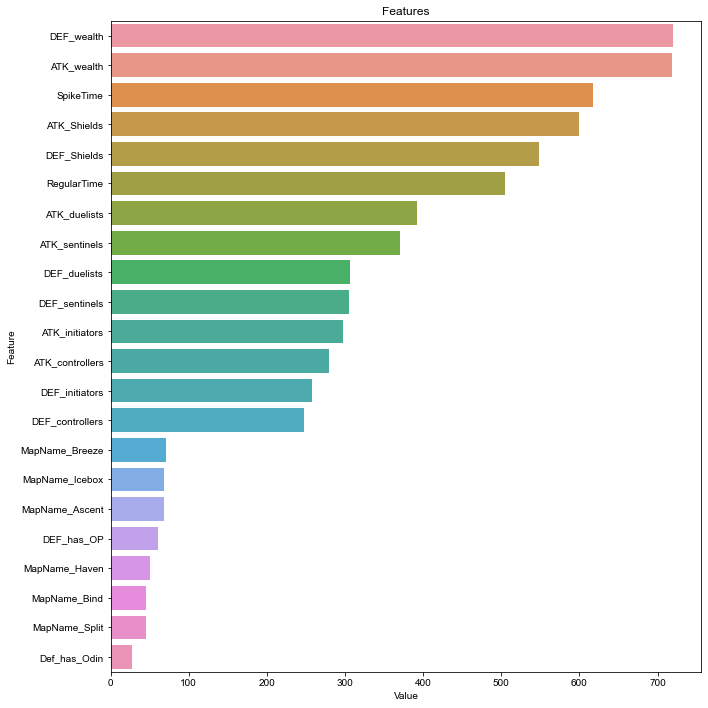

In [13]:
feature_imp = pd.DataFrame(sorted(zip(model.feature_importances_,X.columns)), columns=['Value','Feature'])

plt.figure(figsize=(10, 10))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
sns.set(font_scale = 1)
plt.title('Features')
plt.tight_layout()
plt.show()

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

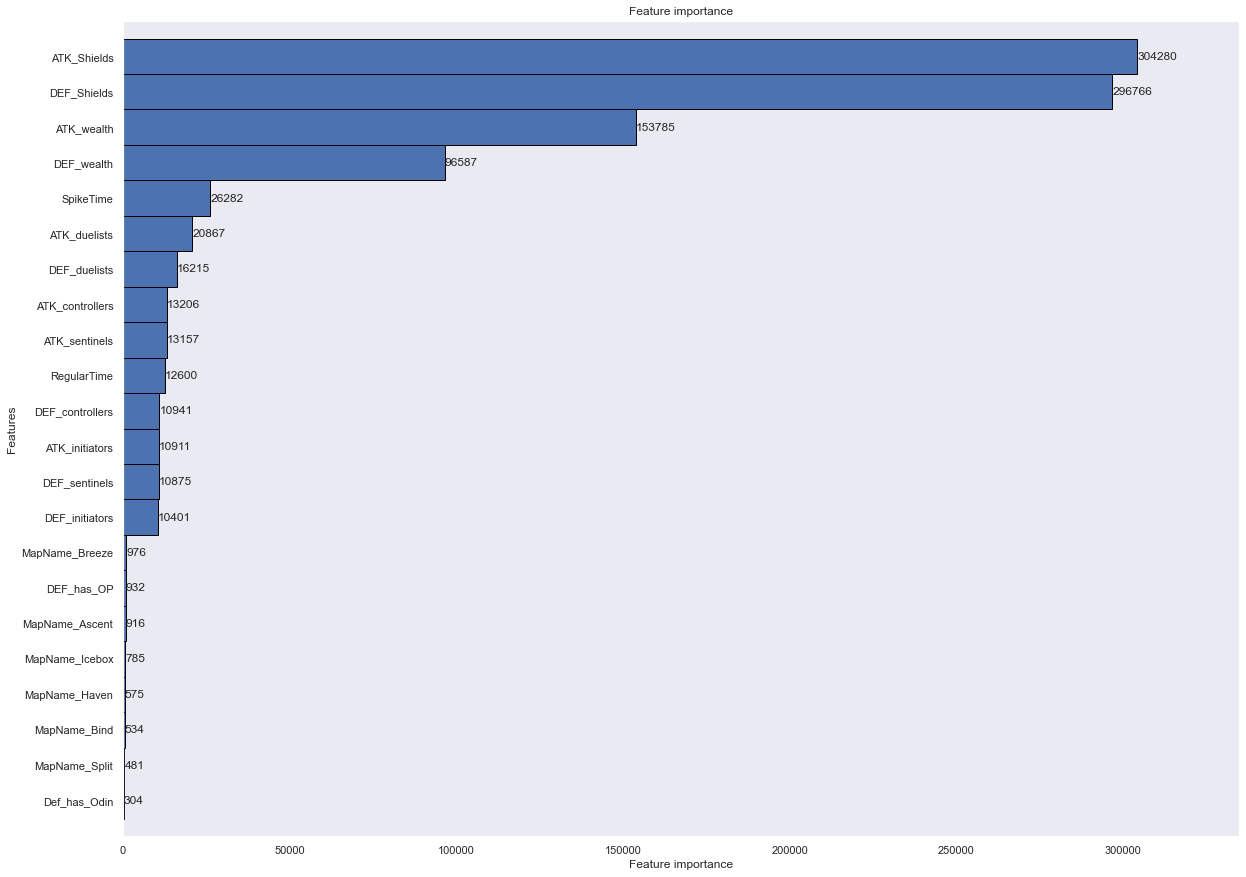

In [14]:
lightgbm.plot_importance(model, height=1, importance_type="gain", precision=0, grid=False, figsize=(20,15), edgecolor='black')

# <font color='blue'>MODEL PRECISION </font>

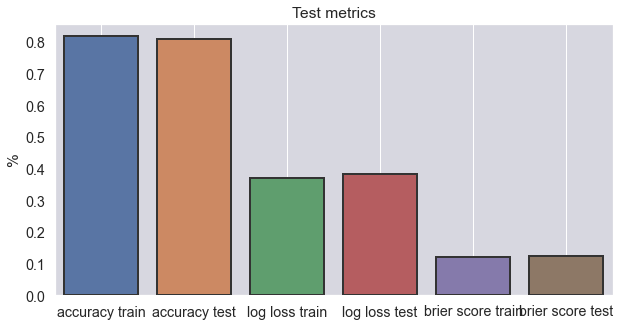

Wall time: 3.1 s


In [15]:
%%time
plt.figure(figsize = (10,5))

pred_proba = model.predict_proba(X_train)
pred_proba_test = model.predict_proba(X_test)

gmt = ["accuracy train", "accuracy test", "log loss train", "log loss test", "brier score train", "brier score test"]
metrics = {'Labels': gmt,
           'Value': [model.score(X_train, Y_train), model.score(X_test, Y_test),
                     log_loss(Y_train, pred_proba),log_loss(Y_test, pred_proba_test),
                     brier_score_loss(Y_train, pd.DataFrame(pred_proba)[1]),brier_score_loss(Y_test, pd.DataFrame(pred_proba_test)[1])]
           }

sns.set_context(rc = {'patch.linewidth': 2.0})
sns.set(font_scale=1.3)
ax = sns.barplot(x='Labels', y='Value', data=metrics, linewidth=2.0, edgecolor=".2", zorder=3, palette=sns.color_palette("deep"))

plt.ylabel('%')
#plt.gca().yaxis.set_major_locator(ticker.MultipleLocator(.1))
ax.grid(linewidth=1, color='white', zorder=0)
ax.set_facecolor("#d7d7e0")
plt.title("Test metrics")
plt.show()

In [16]:
print("Brier score → {}".format(brier_score_loss(Y_test, pd.DataFrame(pred_proba_test)[1])))


Brier score → 0.1255823913446537


# <font color='blue'>REALIBITY CURVE </font>

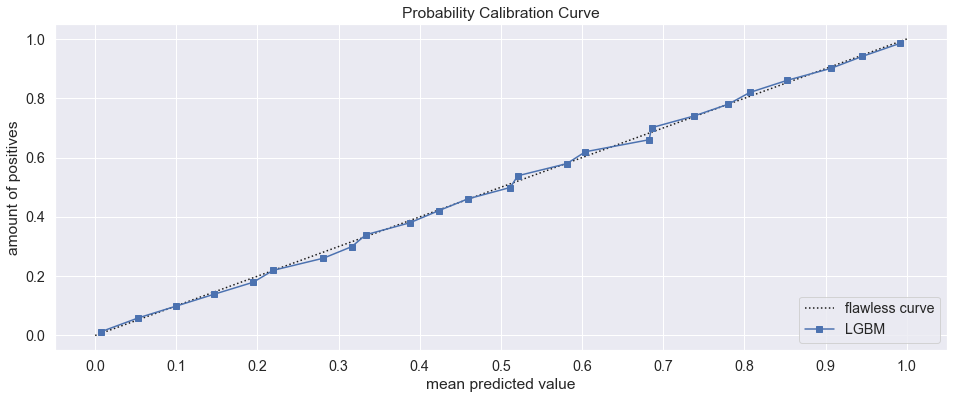

Wall time: 404 ms


Text(0.5, 0, 'mean predicted value')

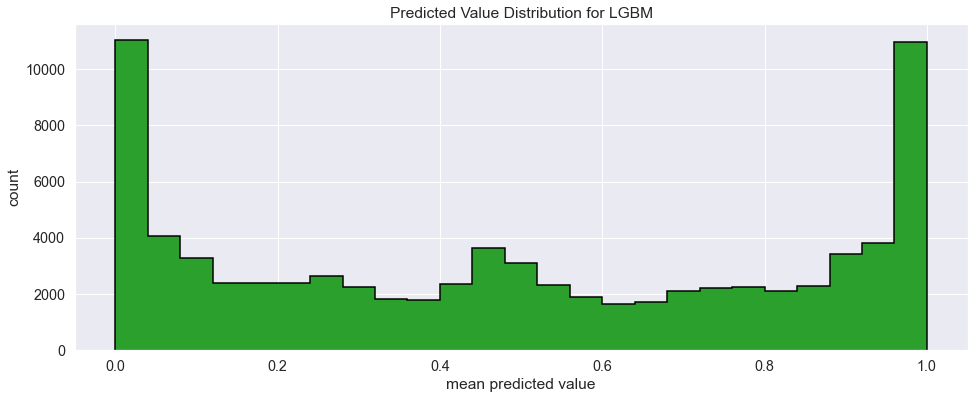

In [17]:
%%time
plt.figure(figsize=(16,6))
plt.plot([0,1], [0,1], 'k:', label='flawless curve')
x, y = calibration_curve(Y_test, pd.DataFrame(pred_proba_test)[1], n_bins=25)
plt.plot(x, y, 's-', label='LGBM')
plt.legend(loc='lower right')
plt.title('Probability Calibration Curve')
plt.ylabel('amount of positives')
plt.xlabel('mean predicted value')
plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(0.1))
plt.show()

plt.figure(figsize=(16,6))
plt.hist(pd.DataFrame(pred_proba_test)[1], range=(0,1), bins=25, histtype="step", lw=2, fill=True, color='tab:green',
        edgecolor='black', linewidth=1.5)
plt.title('Predicted Value Distribution for LGBM')
plt.ylabel('count')
plt.xlabel('mean predicted value')

# <font color='blue'>CONFUSION MATRIX </font>

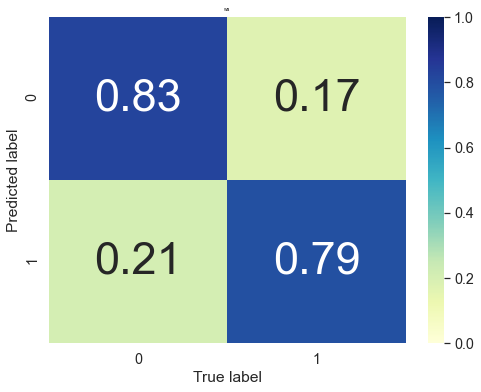

In [18]:
plt.figure(figsize = (8,6))
cm = confusion_matrix(Y_test, model.predict(X_test, num_iteration=50))
cm = (cm/cm.sum(axis=1).reshape(-1,1))

sns.heatmap(cm, cmap="YlGnBu", vmin=0., vmax=1., annot=True, annot_kws={'size':45})
plt.title("wa", fontsize = 5)
plt.ylabel('Predicted label')
plt.xlabel('True label')
plt.show()

In [19]:
Y_pred = model.predict(X_test)
classification_report(Y_test, Y_pred, output_dict=True)["weighted avg"]["f1-score"]

0.8107425791483006